In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import copy
import torch
import numpy as np
import abstract_gradient_training as agt
sys.path.append("..")
from models.fully_connected import FullyConnected
from datasets.uci import get_dataloaders

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

In [56]:
# configure the training parameters
batchsize = 10000
nominal_config = agt.AGTConfig(
    fragsize=10000,
    learning_rate=0.05,
    lr_decay=0.5,
    epsilon=0.01,
    # clip_gamma=0.1,
    k_poison=1000,
    n_epochs=1,
    device="cuda:1",
    forward_bound="interval",
    backward_bound="interval",
    loss="mse",
    log_level="INFO",
    early_stopping=False,
    metadata=f"uci, batchsize={batchsize}",
    bound_kwargs={"interval_matmul": "exact"}
)

In [51]:
# get the data and nn model
torch.manual_seed(0)
dl_train, dl_test = get_dataloaders(batchsize, batchsize, "houseelectric", n_batches=50)
model = FullyConnected(11, 1, 50, 1)  # network with 1 hidden layer of 64 neurons

houseelectric dataset, N=2049280, d=11


In [57]:
conf = copy.deepcopy(nominal_config)

training = []
def log(*args):
    training.append(copy.deepcopy(args))
conf.callback = log

# train the model
param_l, param_n, param_u = agt.poison_certified_training(model, conf, dl_train, dl_test)

# evaluate the trained model
mse = agt.test_metrics.test_mse(param_l, param_n, param_u, *next(iter(dl_test)))
print(f"Test MSE: nominal = {mse[1]:.4g}, certified upper bound = {mse[0]:.4g}, certified lower bound = {mse[2]:.4g}")

[AGT] [INFO    ] [14:37:13] =================== Starting Poison Certified Training ===================
[AGT] [INFO    ] [14:37:13] Starting epoch 1
[AGT] [INFO    ] [14:37:13] Training batch 1: Network eval bounds=(0.21, 0.21, 0.21), W0 Bound=0.0 
[AGT] [INFO    ] [14:37:14] Training batch 2: Network eval bounds=(0.12, 0.12, 0.12), W0 Bound=0.0023 
[AGT] [INFO    ] [14:37:14] Training batch 3: Network eval bounds=(0.091, 0.089, 0.087), W0 Bound=0.0036 
[AGT] [INFO    ] [14:37:14] Training batch 4: Network eval bounds=(0.076, 0.073, 0.071), W0 Bound=0.0046 
[AGT] [INFO    ] [14:37:15] Training batch 5: Network eval bounds=(0.069, 0.066, 0.063), W0 Bound=0.00545 
[AGT] [INFO    ] [14:37:15] Training batch 6: Network eval bounds=(0.064, 0.061, 0.057), W0 Bound=0.00619 
[AGT] [INFO    ] [14:37:15] Training batch 7: Network eval bounds=(0.061, 0.056, 0.052), W0 Bound=0.00688 
[AGT] [INFO    ] [14:37:16] Training batch 8: Network eval bounds=(0.058, 0.054, 0.049), W0 Bound=0.00752 
[AGT] [IN

Test MSE: nominal = 0.0396, certified upper bound = 0.06383, certified lower bound = 0.02259


In [58]:
print([(param_n[i] - param_l[i]).max().item() for i in range(len(param_n))])
print([(param_n[i] - param_l[i]).min().item() for i in range(len(param_n))])
print([(param_u[i] - param_n[i]).max().item() for i in range(len(param_n))])
print([(param_u[i] - param_n[i]).min().item() for i in range(len(param_n))])

print(param_l[-1], param_n[-1], param_u[-1])

[0.0018626898527145386, 0.002836167812347412, 0.012622535228729248, 0.014866798184812069]
[0.0, 0.0, 0.0, 0.014866798184812069]
[0.0018544495105743408, 0.002829045057296753, 0.012588053941726685, 0.014670543372631073]
[0.0, 0.0, 0.0, 0.014670543372631073]
tensor([[-0.0258]], device='cuda:1') tensor([[-0.0109]], device='cuda:1') tensor([[0.0038]], device='cuda:1')


[50, 50, 50, 50]


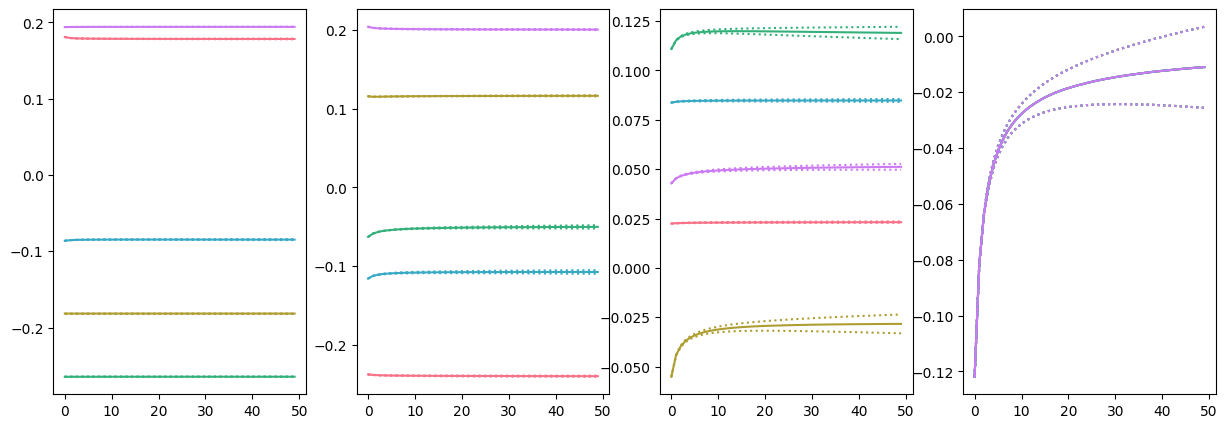

In [59]:
def plot_params(training, n_samples):
    palette = sns.color_palette("husl", n_samples)
    p_l = list(zip(*[t[1] for t in training]))
    p_n = list(zip(*[t[2] for t in training]))
    p_u = list(zip(*[t[3] for t in training]))
    L = len(p_l)
    print([len(p) for p in p_l])
    fig, ax = plt.subplots(1, L, figsize=(15, 5))
    for i in range(L):
        for j in range(n_samples):
            color = palette[j]
            idx = np.random.randint(0, p_l[i][0].flatten().nelement())
            ax[i].plot([p.flatten()[idx].cpu().numpy() for p in p_l[i]], color=color, linestyle=":", label="lower bound")
            ax[i].plot([p.flatten()[idx].cpu().numpy() for p in p_n[i]], color=color, label="nominal")
            ax[i].plot([p.flatten()[idx].cpu().numpy() for p in p_u[i]], color=color, linestyle=":", label="upper bound")

plot_params(training, 5)

In [75]:
def plot_params_2(ax, training, layer, step=5, shift=False):
    p_l = [p.flatten().cpu().numpy() for p in list(zip(*[t[1] for t in training]))[layer]]
    p_n = [p.flatten().cpu().numpy() for p in list(zip(*[t[2] for t in training]))[layer]]
    p_u = [p.flatten().cpu().numpy() for p in list(zip(*[t[3] for t in training]))[layer]]
    L = len(p_l)
    if p_l[0].size == 1:
        raise ValueError
    i = np.random.randint(0, p_l[0].size)
    j = np.random.randint(0, p_l[0].size)
    while j == i:
        j = np.random.randint(0, p_l[0].size)
    palette = sns.color_palette("rocket", n_colors=L // step + 1)

    center = (p_n[0][i], p_n[0][j]) if shift else (0, 0)

    # fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    for k in range(0, L, step):
        x_l = p_l[k][i] - center[0]
        x_u = p_u[k][i] - center[0]
        y_l = p_l[k][j] - center[1]
        y_u = p_u[k][j] - center[1]
        box = mpl.patches.Rectangle(
            (x_l, y_l), x_u - x_l, y_u - y_l, edgecolor=palette[k // step], alpha=0.5, facecolor="none"
        )
        ax.add_patch(box)

    ax.plot(
        [p_n[k][i] - center[0] for k in range(L)],
        [p_n[k][j] - center[1] for k in range(L)],
        color="red",
        label="nominal",
    )
    # ax.set_ylim(min([p_l[k][j] for k in range(L)]), max([p_u[k][j] for k in range(L)]))
    # ax.set_xlim(min([p_l[k][i] for k in range(L)]), max([p_u[k][i] for k in range(L)]))

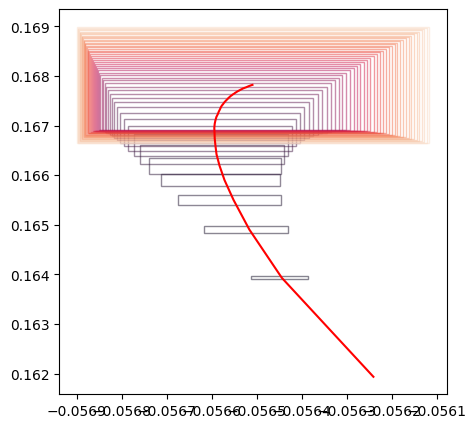

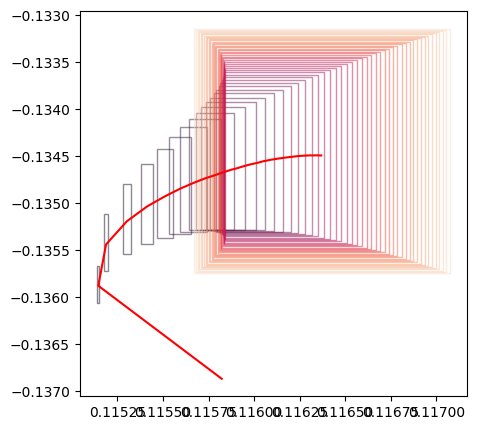

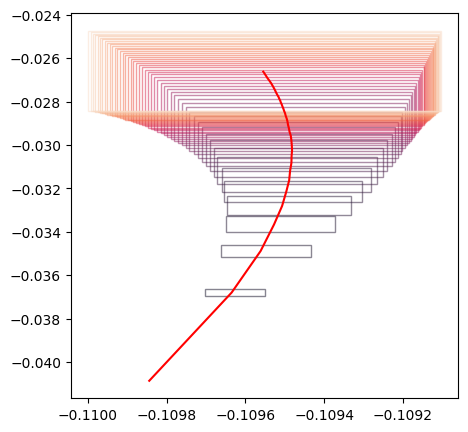

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_params_2(ax, training, 0, 1)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_params_2(ax, training, 1, 1)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_params_2(ax, training, 2, 1)

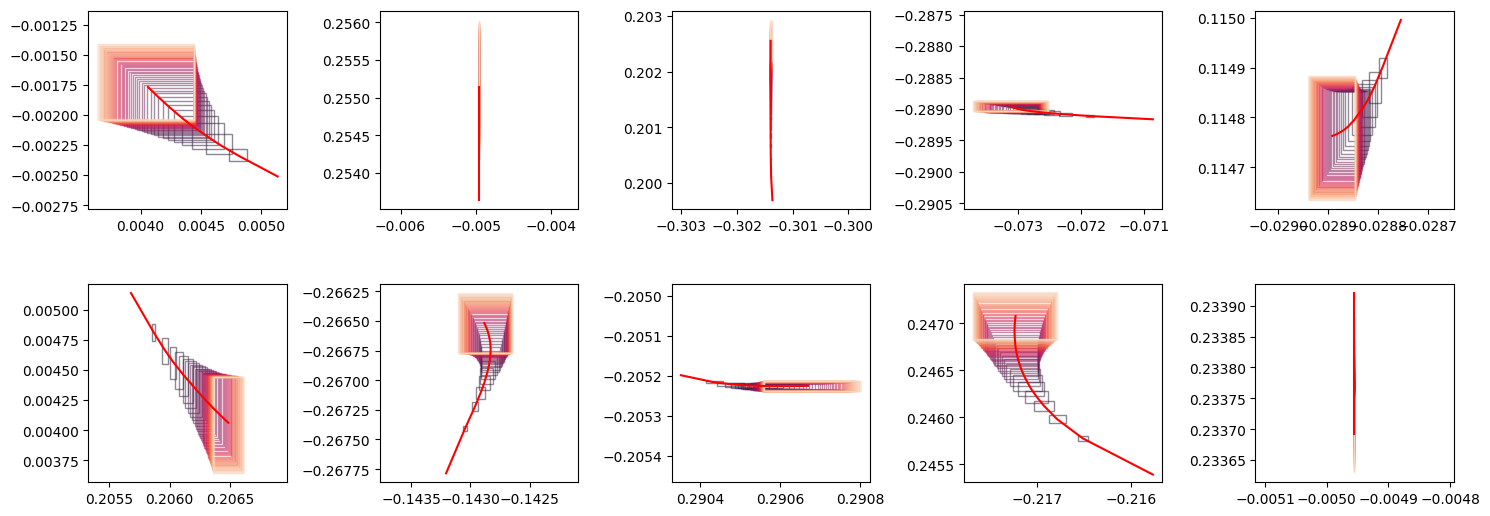

In [111]:
n, m = 2, 5

fig, axs = plt.subplots(n, m, figsize=(m*3, n*3), layout="tight")
[ax.axis("equal") for ax in axs.flatten()]
[ax.set_box_aspect(1) for ax in axs.flatten()]
# plt.axis("scaled")
for i in range(n):
    for j in range(m):
        plot_params_2(axs[i, j], training, 0, 1)

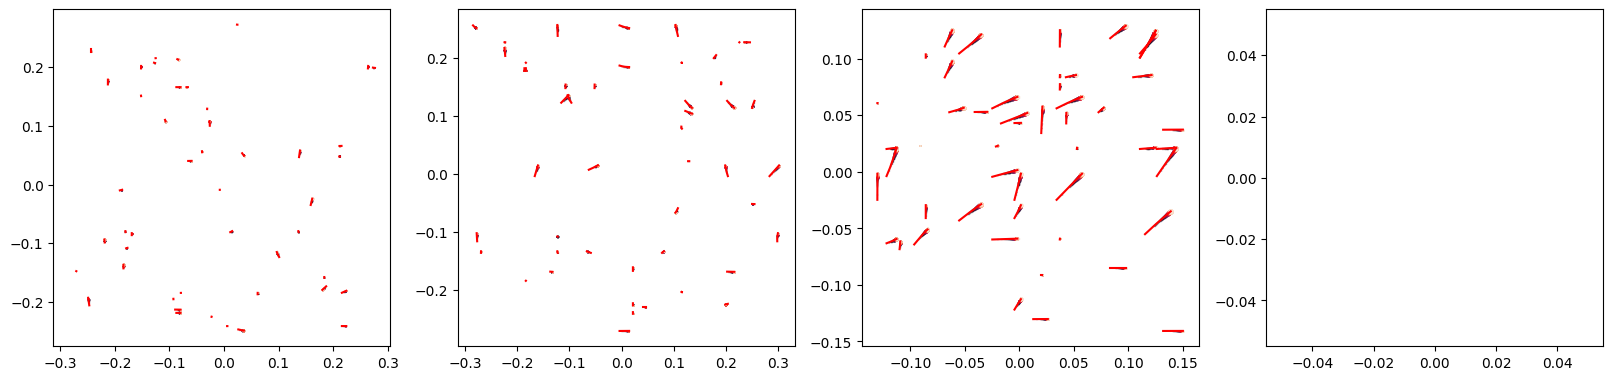

In [26]:

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
[ax.set_box_aspect(1) for ax in axs]
plt.axis('scaled')
for _ in range(50):
    plot_params_2(axs[0], training, 0, 1)
    plot_params_2(axs[1], training, 1, 1)
    plot_params_2(axs[2], training, 2, 1)
    plot_params_2(axs[3], training, 3, 1)
# plot_params_2(training, 1, 1)
# plot_params_2(training, 2, 1)
# plot_params_2(training, 3, 1)